In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subjects .csv

In [6]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_05.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [7]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
0,psilocybin,676727,aw_psi_2023-05-10_09-49-12,"awake,psilocybin,psilocybin",deep,29,True,F:\psi_exp\mouse676727\aw_psi_2023-05-10_09-49...,25,only has one estim current
1,isoflurane,676727,aw_iso_2023-05-11_09-44-46,"awake,isoflurane",deep,29,True,F:\psi_exp\mouse676727\aw_iso_2023-05-11_09-44...,25,only has one estim current
2,urethane,676727,urethane_2023-05-12_11-35-38,urethane,deep,29,True,F:\psi_exp\mouse676727\urethane_2023-05-12_11-...,25,only has one estim current
3,psilocybin,689242,aw_psi_2023-07-19_10-29-49,"awake,psilocybin,psilocybin",deep,"13,16",True,F:\psi_exp\mouse689242\aw_psi_2023-07-19_10-29...,25,NaN
4,isoflurane,689242,aw_iso_2023-07-20_10-52-57,"awake,isoflurane",deep,13,True,F:\psi_exp\mouse689242\aw_iso_2023-07-20_10-52...,25,NaN


### Choose a subject

In [8]:
testsub = subject_df.iloc[2]
print('{}: {}'.format(testsub.mouse, testsub.experiment))
testsubexp = EEGexp(testsub.data_loc, preprocess=False, make_stim_csv=False)

676727: urethane_2023-05-12_11-35-38
Experiment type: electrical and sensory stimulation


In [9]:
## Grab exp metadata from Templeton-log_exp ##
exp_meta = metadata[(
    (metadata['mouse_name'].str.contains(testsub.mouse)) &
    (metadata['exp_name'].str.contains(testsub.experiment))
)].squeeze()

## Get injection times ##
if testsub.exp_type in ['psilocybin', 'ketanserin']:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
else:
    print('This {} experiment has no injection times.'.format(testsub.exp_type))
    inj_times = None

This urethane experiment has no injection times.


In [10]:
## Get bad EEG channels ##
badchstr = testsub.bad_chs.replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

[29]


In [11]:
## Load stim log ##
stim_log = pd.read_csv(testsubexp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,40,431.64557,431.64597,0.0004,0,False,0.0,True
1,biphasic,40,438.25267,438.25307,0.0004,0,True,0.0,True
2,biphasic,40,445.71502,445.71542,0.0004,0,True,0.0,True
3,biphasic,40,452.22010,452.22050,0.0004,0,True,0.0,True
4,biphasic,40,459.49547,459.49587,0.0004,0,True,0.0,True


In [13]:
## Get state label for each sweep ##
all_sweeps = np.unique(stim_log['sweep'].values)
sweep_state_list = []
for char in testsub.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
# if call_saline_awake:
#     stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]

## Get list of states and the middle current ##
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
else:
    estim_current = {'mid': str(currents[0])}

In [14]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
0,biphasic,40,431.64557,431.64597,0.0004,0,False,0.0,True,urethane
1,biphasic,40,438.25267,438.25307,0.0004,0,True,0.0,True,urethane
2,biphasic,40,445.71502,445.71542,0.0004,0,True,0.0,True,urethane
3,biphasic,40,452.22010,452.22050,0.0004,0,True,0.0,True,urethane
4,biphasic,40,459.49547,459.49587,0.0004,0,True,0.0,True,urethane


In [15]:
## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(testsubexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(testsubexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(GOOD_CHS))

29


#### Load and plot running and pupil signal

In [16]:
running_file = os.path.join(testsubexp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(testsubexp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [17]:
pupil_file = glob(os.path.join(testsubexp.data_folder, 'Pupileye*'), recursive=True)[0]
pupildf = pd.read_csv(pupil_file)
# pupildf.head()

pupilts = pupildf.sync_time.values
pupilD = pupildf.Largest_Radius.values
eyeD = pupildf.Eye_Diameter.values

## Smooth eye diameter ##
smooth_eyeD = np.zeros_like(eyeD)
k = 50 # filter window is actually k*2+1
for i in range(k, len(eyeD)-k-1):
    smooth_eyeD[i] = np.mean(eyeD[i-k:i+k]) # each point is the average of k surrounding points
smooth_eyeD[:k] = eyeD[:k]
smooth_eyeD[-k-1:] = eyeD[-k-1:]

normpupil = pupilD / smooth_eyeD

<IPython.core.display.Javascript object>


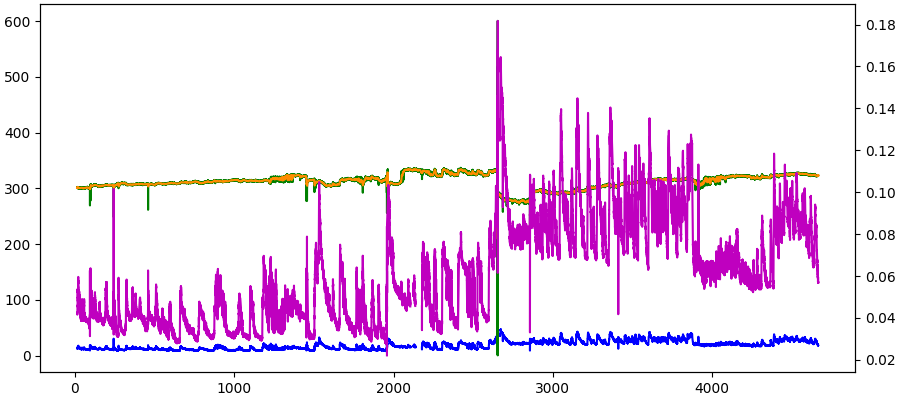

In [19]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(pupilts, pupilD, 'b')
ax.plot(pupilts, eyeD, 'g')
ax.plot(pupilts, smooth_eyeD, 'darkorange')

ax2 = ax.twinx()
ax2.plot(pupilts, normpupil, 'm')

<IPython.core.display.Javascript object>


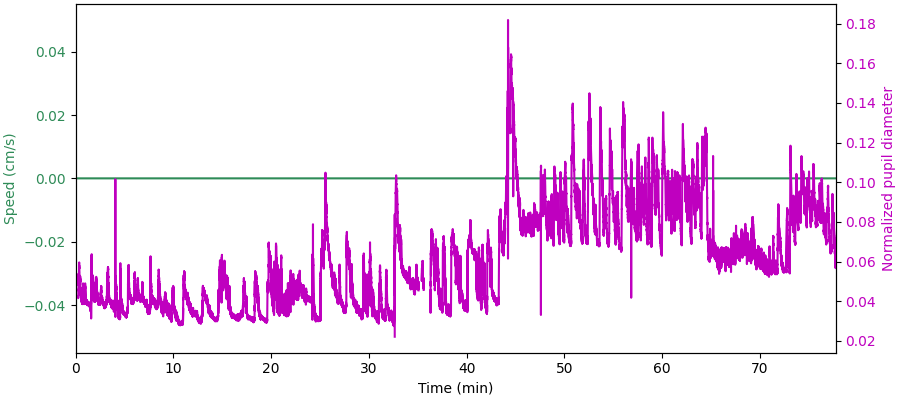

In [18]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(speedts/60, speed, 'seagreen')
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='darkorange')
        
ax2 = ax.twinx()
ax2.plot(pupilts/60, normpupil, 'm')
ax2.set_ylabel('Normalized pupil diameter', color='m')
ax2.tick_params(axis='y', labelcolor='m')

### Get state-based evoked potential

In [25]:
# event_types = ['estim': 'biphasic', 'visual': 'circle']
stimcheck = 'biphasic'
estimlog = stim_log[stim_log['stim_type'] == stimcheck]

600
360


In [58]:
EEG_traces = {}

for statei in states:
    print(statei)
    EEG_traces[statei] = {}
    
    for clevel, parami in estim_current.items():
        print(' {} current'.format(clevel))
        
        event_inds = get_events_wdict(estimlog, {'state': statei, 'parameter': parami}, out='index')
        event_traces = all_EEG_traces[:, :, event_inds]
        ## Apply common average reference ##
        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
        EEG_traces[statei][clevel] = [EEG_event_timestamps, event_traces]

awake
 mid current
psilocybin
 mid current


<IPython.core.display.Javascript object>


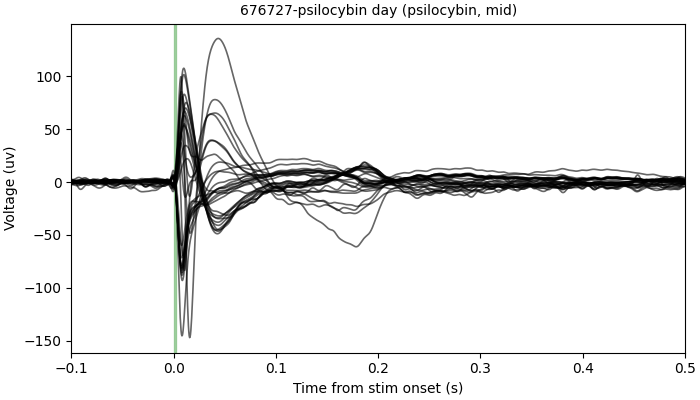

Text(0.5, 1.0, '676727-psilocybin day (psilocybin, mid)')

In [66]:
pstate = 'psilocybin'
pcurr = 'mid'

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

timex = EEG_traces[pstate][pcurr][0]
# alltraces = EEG_traces[pstate][pcurr][1]
ep = np.mean(EEG_traces[pstate][pcurr][1], axis=2)

ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(timex, ep[:, GOOD_CHS], 'k', linewidth=1.2, alpha=0.6)
ax.set_xlim([-0.1, 0.5])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uv)')
ax.set_title('{}-{} day ({}, {})'.format(testsub.mouse, testsub.exp_type, pstate, pcurr))

In [8]:
subjects_data = {}
for mouse, explist in subjects.items():
    subjects_data[mouse] = {}
    for exptype, dataloc in explist.items():
        subjects_data[mouse][exptype] = {}
        print('{}: {}'.format(mouse, exptype))
        subjects_data[mouse][exptype]['exp'] = EEGexp(dataloc, preprocess=False, make_stim_csv=False)

673449: psilocybin1
Experiment type: electrical stimulation
673449: psilocybin2
Experiment type: electrical stimulation
673449: saline
Experiment type: electrical stimulation


In [9]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

### Load eeg data and gather stim-evoked traces per sweep

In [10]:
## parameters ##
apply_car = True

In [11]:
for mouse, expdict in subjects_data.items():
    for exptype, mdata in expdict.items():
        print('{}: {}'.format(mouse, exptype))
        
        ## Grab exp metadata from Templeton-log_exp ##
        exp_meta = metadata[(
            (metadata['mouse_name'].str.contains(mouse)) &
            (metadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        badchstr = exp_meta['EEG bad_channels'].replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        mdata['inj_times'] = [float(exp_meta['First injection time']), float(exp_meta['Second injection time'])]
                
        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file).astype({'parameter': str})
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Get evoked traces ##
        EEG_traces = {}
        sweep_info = []
        for st_type in stim_log.stim_type.unique():
            EEG_traces[st_type] = {}
            param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
            for parami in param_list:
                EEG_traces[st_type][parami] = {}
                sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
                for sweepi in sweep_list:
                    EEG_traces[st_type][parami][sweepi] = {}
                    ## Get traces for all trials ##
                    eventinds = get_stim_event_inds(stim_log, st_type, parami, sweepi, trials='all')
                    event_traces = all_EEG_traces[:, :, eventinds]
                    if apply_car:
                        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    EEG_traces[st_type][parami][sweepi]['all'] = [EEG_event_timestamps, event_traces]
                    
                    ## Store sweep info ##
                    sweep_info.append([
                        st_type, parami, sweepi, stim_log['onset'].iloc[eventinds].values[0],
                        stim_log['onset'].iloc[eventinds].values[-1], np.mean(stim_log['onset'].iloc[eventinds].values)
                    ])
                    
                    del eventinds, event_traces
                    ## Get traces for resting trials ##
                    eventinds = get_stim_event_inds(stim_log, st_type, parami, sweepi, trials='resting')
                    event_traces = all_EEG_traces[:, :, eventinds]
                    if apply_car:
                        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    EEG_traces[st_type][parami][sweepi]['resting'] = [EEG_event_timestamps, event_traces]
                    del eventinds, event_traces
                    ## Get traces for running trials ##
                    eventinds = get_stim_event_inds(stim_log, st_type, parami, sweepi, trials='running')
                    event_traces = all_EEG_traces[:, :, eventinds]
                    if apply_car:
                        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    EEG_traces[st_type][parami][sweepi]['running'] = [EEG_event_timestamps, event_traces]
                    del eventinds, event_traces
            
        mdata['EEG_traces'] = EEG_traces
        mdata['sweep_info_df'] = pd.DataFrame(
            sweep_info, columns=['stim', 'parameter', 'sweep', 'sweep_onset', 'sweep_offset', 'sweep_time']
        )
        del stim_log, all_EEG_traces, EEG_event_timestamps, sweep_info

673449: psilocybin1
673449: psilocybin2
673449: saline


In [12]:
mdata['sweep_info_df'].head()

,stim,parameter,sweep,sweep_onset,sweep_offset,sweep_time
0,biphasic,50,0,154.09467,744.86561,455.843773
1,biphasic,50,1,1650.64758,2241.41864,1944.391041
2,biphasic,50,2,2275.73756,2866.50858,2560.638920
3,biphasic,50,3,2939.78123,3520.48280,3234.633902
4,biphasic,50,4,3610.18992,4200.96088,3906.718275


### Calculate ERP metrics for all subjects

The following loop will only work for experiments with one current.

In [12]:
stim = 'biphasic'
zlim = 3

PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
trial_lim = 30

In [13]:
for mouse, expdict in subjects_data.items():
    for exptype, mdata in expdict.items():
        print('{}: {}'.format(mouse, exptype))
        EEG_sample_rate = mdata['exp'].ephys_params['EEG']['sample_rate']

        for curri, sweepdict in mdata['EEG_traces'][stim].items():
            sweep_info = mdata['sweep_info_df'][
                (mdata['sweep_info_df']['stim'] == stim) & (mdata['sweep_info_df']['parameter'] == curri)
            ].copy()
            sweep_metrics = []
            for sweepi, trialdict in sweepdict.items():
                trial_type_info = [sweepi]
                collabels = ['sweep']
                for trialtype, datai in trialdict.items():
                    collabels.extend([
                        trialtype + '_trial_count', trialtype + '_duration', trialtype + '_magnitude', trialtype + '_PCI'
                    ])
                    num_trials = datai[1].shape[2]
                    EEG_time = datai[0]
                    EEG_traces = datai[1]
                    
                    trial_type_info.append(num_trials)
                    if num_trials == 0:
                        print(' *sweep {:d}: no {} trials*'.format(sweepi, trialtype))
                        trial_type_info.extend([np.nan, np.nan, np.nan])
                        continue
                        
                    state_traces = np.mean(EEG_traces, axis=2)
                    ## Calculate global field power duration ##
                    gfpow = np.std(state_traces[:, mdata['good_chs']], axis=1)
                    blmean = np.mean(gfpow[EEG_time < 0])
                    blstd = np.std(gfpow[EEG_time < 0])
                    zgfpow = (gfpow - blmean) / blstd
                    response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
                    ## Area under global field power curve ##
                    zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
                    auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')
                    trial_type_info.extend([response_duration, auc])
                    
                    ## Calulate PCIst ##
                    if num_trials >= trial_lim:
                        PCIval = calc_PCIst(state_traces[:, mdata['good_chs']].T, EEG_time, **PCI_params)
                        trial_type_info.append(PCIval)
                    else:
                        trial_type_info.append(np.nan)
                    
                sweep_metrics.append(trial_type_info)
            sweep_metrics_df = sweep_info.merge(pd.DataFrame(sweep_metrics, columns=collabels), on='sweep', how='left')
        mdata['sweep_metrics'] = sweep_metrics_df
        print('')

673449: psilocybin1

673449: psilocybin2

673449: saline



### Make a plot for each subject, both days

In [14]:
subjects_data['673449'].keys()

dict_keys(['psilocybin1', 'psilocybin2', 'saline'])

<IPython.core.display.Javascript object>


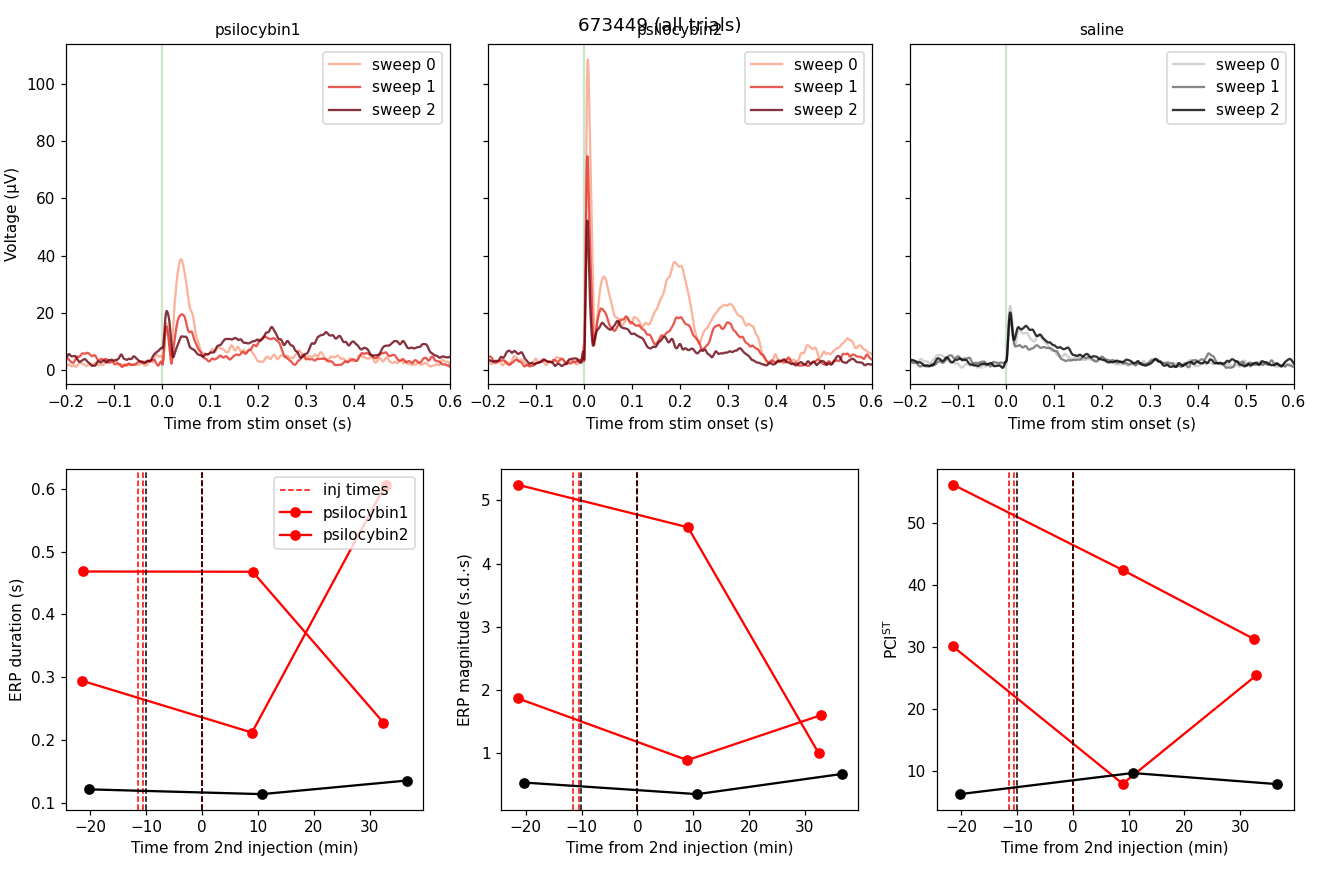

In [15]:
trials = 'all' # 'resting', 'running', 'all'
plot_window = [-0.2, 0.6]

for mouse, expdict in subjects_data.items():
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(ncols=1, nrows=2, left=0.05, right=0.98, top=0.95, bottom=0.08, hspace=0.25)
    ERPaxs = gs[0].subgridspec(ncols=len(expdict), nrows=1, wspace=0.1).subplots(sharex=True, sharey=True)
    METaxs = gs[1].subgridspec(ncols=3, nrows=1, wspace=0.22).subplots()
    for i, (exptype, mdata) in enumerate(expdict.items()):
        curr = list(mdata['EEG_traces'][stim].keys())[0]
        sweep_met_df = mdata['sweep_metrics']
        num_sweeps = len(mdata['EEG_traces'][stim][curr])

        if 'saline' in exptype:
            colors = plt.cm.Greys(np.linspace(0, 1, num_sweeps+1))
            linec = 'k'
        elif 'psilocybin' in exptype:
            colors = plt.cm.Reds(np.linspace(0, 1, num_sweeps+1))
            linec = 'r'

        ## Plot ERPs for all sweeps ##
        ERPaxs[i].axvline(0, color='g', alpha=0.2)
        for sweepi in range(num_sweeps):
            timex = mdata['EEG_traces'][stim][curr][sweepi][trials][0]
            traces = np.mean(mdata['EEG_traces'][stim][curr][sweepi][trials][1], axis=2)
            gfpow = np.std(traces[:, mdata['good_chs']], axis=1)
            ERPaxs[i].plot(timex, gfpow, color=colors[sweepi+1], linewidth=1.5, alpha=0.8, label='sweep ' + str(sweepi))
        ERPaxs[i].legend(loc='upper right')
        ERPaxs[i].set_xlabel('Time from stim onset (s)')
        ERPaxs[i].set_title(exptype)

        ## Plot metrics ##
        for j, meti in enumerate(['duration', 'magnitude', 'PCI']):
            metric_name = trials + '_' + meti
            zero_time = mdata['inj_times'][-1]
            if i == 0:
                METaxs[j].set_xlabel('Time from 2nd injection (min)')
            for inji in mdata['inj_times']:
                METaxs[j].axvline((inji - zero_time) / 60, color=linec, linewidth=1.0, linestyle='dashed', label='inj times')
            METaxs[j].plot(
                (sweep_met_df['sweep_time'].values - zero_time) / 60, sweep_met_df[metric_name].values,
                color=linec, marker='o', label=exptype
            )


    ERPaxs[0].set_xlim(plot_window)
    ERPaxs[0].set_ylabel('Voltage (\u03bcV)')
    METaxs[0].set_ylabel('ERP duration (s)')
    METaxs[1].set_ylabel('ERP magnitude (s.d.$\cdot$s)')
    METaxs[2].set_ylabel('$\mathregular{PCI^{ST}}$')

    ## Bottom legend ##
    handles, labels = METaxs[0].get_legend_handles_labels()
    mhandles = [handles[0], handles[2], handles[5]]
    mlabels = [labels[0], labels[2], labels[5]]
    METaxs[0].legend(mhandles, mlabels, loc='upper right')

    ## Title ##
    fig.text(0.5, 0.97, '{} ({} trials)'.format(mouse, trials), rotation='horizontal', va='center', ha='center', fontsize=12)
    
    ## Save ##
    figname = '{}_ERPmetrics_allsweeps_{}trials.png'.format(mouse, trials)
    fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Test one subject plot

Test one subject, plot normalized metrics

<IPython.core.display.Javascript object>


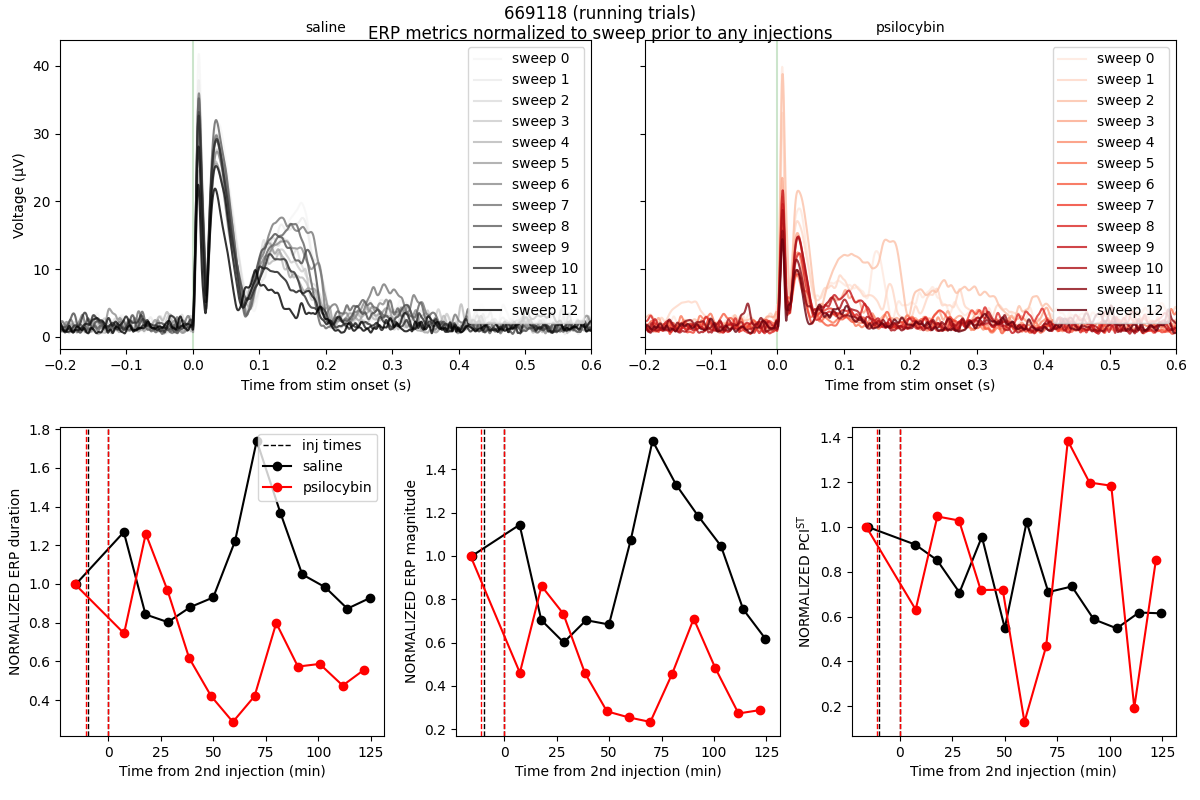

In [135]:
subject = '669118'
trials = 'running' # 'resting', 'running'
plot_window = [-0.2, 0.6]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.05, right=0.98, top=0.95, bottom=0.08, hspace=0.25)
ERPaxs = gs[0].subgridspec(ncols=2, nrows=1, wspace=0.1).subplots(sharex=True, sharey=True)
METaxs = gs[1].subgridspec(ncols=3, nrows=1, wspace=0.22).subplots()

for i, exptype in enumerate(['saline', 'psilocybin']):
    mdata = subjects_data[subject][exptype]
    curr = list(mdata['EEG_traces'][stim].keys())[0]
    sweep_met_df = mdata['sweep_metrics']
    num_sweeps = len(mdata['EEG_traces'][stim][curr])
    
    if exptype == 'saline':
        colors = plt.cm.Greys(np.linspace(0, 1, num_sweeps+1))
        linec = 'k'
    elif exptype == 'psilocybin':
        colors = plt.cm.Reds(np.linspace(0, 1, num_sweeps+1))
        linec = 'r'
    
    ## Plot ERPs for all sweeps ##
    ERPaxs[i].axvline(0, color='g', alpha=0.2)
    for sweepi in range(num_sweeps):
        timex = mdata['EEG_traces'][stim][curr][sweepi][trials][0]
        traces = np.mean(mdata['EEG_traces'][stim][curr][sweepi][trials][1], axis=2)
        gfpow = np.std(traces[:, mdata['good_chs']], axis=1)
        ERPaxs[i].plot(timex, gfpow, color=colors[sweepi+1], linewidth=1.5, alpha=0.8, label='sweep ' + str(sweepi))
    ERPaxs[i].legend(loc='upper right')
    ERPaxs[i].set_xlabel('Time from stim onset (s)')
    ERPaxs[i].set_title(exptype)
    
    ## Plot metrics ##
    for j, meti in enumerate(['duration', 'magnitude', 'PCI']):
        metric_name = trials + '_' + meti
        zero_time = mdata['inj_times'][-1]
        metric_norm = sweep_met_df[metric_name].values / sweep_met_df[metric_name].values[0]
        if i == 0:
            METaxs[j].set_xlabel('Time from 2nd injection (min)')
        for inji in mdata['inj_times']:
            METaxs[j].axvline((inji - zero_time) / 60, color=linec, linewidth=1.0, linestyle='dashed', label='inj times')
        METaxs[j].plot(
            (sweep_met_df['sweep_time'].values - zero_time) / 60, metric_norm, color=linec, marker='o', label=exptype
        )
        
ERPaxs[0].set_xlim(plot_window)
ERPaxs[0].set_ylabel('Voltage (\u03bcV)')
METaxs[0].set_ylabel('NORMALIZED ERP duration')
METaxs[1].set_ylabel('NORMALIZED ERP magnitude')
METaxs[2].set_ylabel('NORMALIZED $\mathregular{PCI^{ST}}$')

## Bottom legend ##
handles, labels = METaxs[0].get_legend_handles_labels()
mhandles = [handles[0], handles[2], handles[5]]
mlabels = [labels[0], labels[2], labels[5]]
METaxs[0].legend(mhandles, mlabels, loc='upper right')

## Title ##
fig.text(0.5, 0.97, '{} ({} trials)\nERP metrics normalized to sweep prior to any injections'.format(subject, trials), rotation='horizontal', va='center', ha='center', fontsize=12)

## Save ##
figname = '{}_NORM_ERPmetrics_allsweeps_{}trials.png'.format(subject, trials)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Combined plot with resting only: 0-60 min and 60-120 min

In [70]:
## This is for resting only ##
windows = {'0-60 min': [0., 3600.], '60-120 min': [3600., 7200.]}
stim = 'biphasic'
ttype = 'resting'

for mouse, expdict in subjects_data.items():
    trial_counts = {key: [] for key in windows.keys()}
    for exptype, mdata in expdict.items():
        curr = list(mdata['EEG_traces'][stim].keys())[0]
        zero_time = mdata['inj_times'][-1]
        
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file).astype({'parameter': str})
        stim_log['onset_from_inj2'] = stim_log['onset'] - zero_time
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        
        print('{} - {}'.format(mouse, exptype))
        for wt, windowi in windows.items():
            if ttype == 'resting':
                eventinds = stim_log[
                    (stim_log['stim_type'] == stim) &
                    (stim_log['parameter'] == curr) &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == True) &
                    (stim_log['onset_from_inj2'] > windowi[0]) &
                    (stim_log['onset_from_inj2'] < windowi[1])
                ].index.values
            elif ttype == 'running':
                eventinds = stim_log[
                    (stim_log['stim_type'] == stim) &
                    (stim_log['parameter'] == curr) &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == False) &
                    (stim_log['onset_from_inj2'] > windowi[0]) &
                    (stim_log['onset_from_inj2'] < windowi[1])
                ].index.values
            else:
                eventinds = stim_log[
                    (stim_log['stim_type'] == stim) &
                    (stim_log['parameter'] == curr) &
                    (stim_log['good'] == True) &
                    (stim_log['onset_from_inj2'] > windowi[0]) &
                    (stim_log['onset_from_inj2'] < windowi[1])
                ].index.values
            print(' {}: {:d} {} trials'.format(wt, len(eventinds), ttype))
            trial_counts[wt].append(len(eventinds))
            event_traces = all_EEG_traces[:, :, eventinds]
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, mdata['good_chs'], :], axis=1)[:,None,:]
            mdata['EEG_traces'][wt] = [EEG_event_timestamps, event_traces]
            
            
        del stim_log, all_EEG_traces, EEG_event_timestamps
        print('')
    subjects_data[mouse]['trial_counts'] = trial_counts
    print('')

666194 - saline
 0-60 min: 20 resting trials
 60-120 min: 36 resting trials

666194 - psilocybin
 0-60 min: 417 resting trials
 60-120 min: 241 resting trials


669118 - saline
 0-60 min: 304 resting trials
 60-120 min: 167 resting trials

669118 - psilocybin
 0-60 min: 17 resting trials
 60-120 min: 21 resting trials


669117 - saline
 0-60 min: 498 resting trials
 60-120 min: 441 resting trials

669117 - psilocybin
 0-60 min: 531 resting trials
 60-120 min: 504 resting trials




### Now get ERP metrics and PCI, matching trial numbers

In [71]:
zlim = 3
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
trial_lim = 30

In [107]:
all_subjects_window_metrics = []
for mouse, expdict in subjects_data.items():
    print(mouse)
    for wt, windowi in windows.items():
        NUM_TRIALS = min(expdict['trial_counts'][wt])
        print(' {}: {:d} {} trials'.format(wt, NUM_TRIALS, ttype))
        
        day_metrics = [mouse, wt, NUM_TRIALS]
        day_labels = ['mouse', 'window', 'trial_count']
        for exptype in ['saline', 'psilocybin']:
            print('  {}'.format(exptype))
            EEG_sample_rate = expdict[exptype]['exp'].ephys_params['EEG']['sample_rate']
            EEG_time = expdict[exptype]['EEG_traces'][wt][0]
            EEG_traces = expdict[exptype]['EEG_traces'][wt][1]
            
            ## Randomly down-select trials to match trial numbers ##
            tinds = np.random.choice(EEG_traces.shape[2], size=NUM_TRIALS, replace=False)
            state_traces = np.mean(EEG_traces[:,:,tinds], axis=2)
            
            ## Calculate global field power duration ##
            gfpow = np.std(state_traces[:, expdict[exptype]['good_chs']], axis=1)
            blmean = np.mean(gfpow[EEG_time < 0])
            blstd = np.std(gfpow[EEG_time < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
            
            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')

            ## Calulate PCIst ##
            PCIval = calc_PCIst(state_traces[:, expdict[exptype]['good_chs']].T, EEG_time, **PCI_params)
            
            ## Store it ##
            day_metrics.extend([response_duration, auc, PCIval])
            day_labels.extend([exptype + '_duration', exptype + '_magnitude', exptype + '_PCI'])

        all_subjects_window_metrics.append(day_metrics)
    print('')
ERP_metrics_df = pd.DataFrame(all_subjects_window_metrics, columns=day_labels)

666194
 0-60 min: 20 resting trials
  saline
  psilocybin
 60-120 min: 36 resting trials
  saline
  psilocybin

669118
 0-60 min: 17 resting trials
  saline
  psilocybin
 60-120 min: 21 resting trials
  saline
  psilocybin

669117
 0-60 min: 498 resting trials
  saline
  psilocybin
 60-120 min: 441 resting trials
  saline
  psilocybin



In [108]:
ERP_metrics_df.head()

,mouse,window,trial_count,saline_duration,saline_magnitude,saline_PCI,psilocybin_duration,psilocybin_magnitude,psilocybin_PCI
0,666194,0-60 min,20,0.3192,2.530811,26.342757,0.3028,1.263082,29.585564
1,666194,60-120 min,36,0.3204,1.805607,21.897143,0.3260,1.756863,20.790276
2,669118,0-60 min,17,0.4152,2.300075,32.530526,0.2352,0.541418,25.854035
3,669118,60-120 min,21,0.3664,3.338034,31.026967,0.0852,0.103071,0.000000
4,669117,0-60 min,498,0.5736,11.752501,63.443509,0.2116,1.045968,22.373333


### Plot

<IPython.core.display.Javascript object>


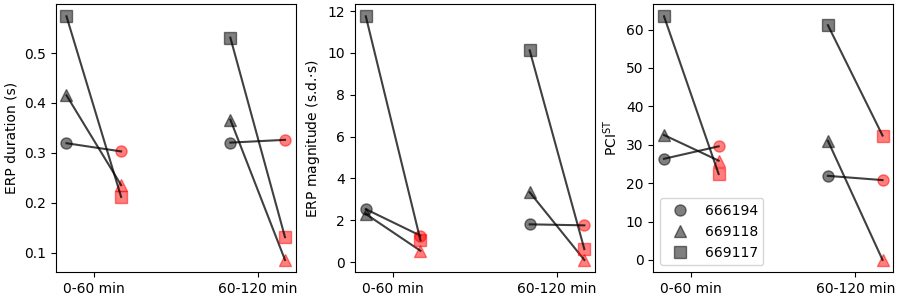

In [129]:
sub_markers = {'666194': 'o', '669118': '^', '669117': 's'}
daycolors = {'saline': 'k', 'psilocybin': 'r'}
metrics = ['duration', 'magnitude', 'PCI']

locs = np.arange((len(daycolors) + 1) * len(windows)).reshape((len(windows), (len(daycolors) + 1)))

fig, axs = plt.subplots(1, len(metrics), figsize=(9,3), constrained_layout=True, sharex=True)
for ax, meti in zip(axs, metrics):
    for k, wini in enumerate(windows.keys()):
        subdf = ERP_metrics_df[ERP_metrics_df['window'] == wini]
        for i, row in subdf.iterrows():
            xvals = []
            yvals = []
            for j, (exptype, ecol) in enumerate(daycolors.items()):
                ax.plot(locs[k,j], row[exptype + '_' + meti], color=ecol, marker=sub_markers[row.mouse], alpha=0.5, markersize=8)
                xvals.append(locs[k,j])
                yvals.append(row[exptype + '_' + meti])
            ax.plot(xvals, yvals, color='k', alpha=0.75)

axs[0].set_xticks(np.mean(locs[:,:-1], axis=1))
axs[0].set_xticklabels(windows.keys())
axs[0].set_ylabel('ERP duration (s)')
axs[1].set_ylabel('ERP magnitude (s.d.$\cdot$s)')
axs[2].set_ylabel('$\mathregular{PCI^{ST}}$')

## Add legends ##
subhandles = []
for subi, marki in sub_markers.items():
    subhandles.append(Line2D([],[], color='k', linestyle='none', marker=marki, markersize=8, alpha=0.5))
axs[2].legend(handles=subhandles, labels=sub_markers.keys())

## Save ##
figname = 'multisubject_ERPmetrics_{}trials.png'.format(mouse, ttype)
fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Some plotting

<IPython.core.display.Javascript object>


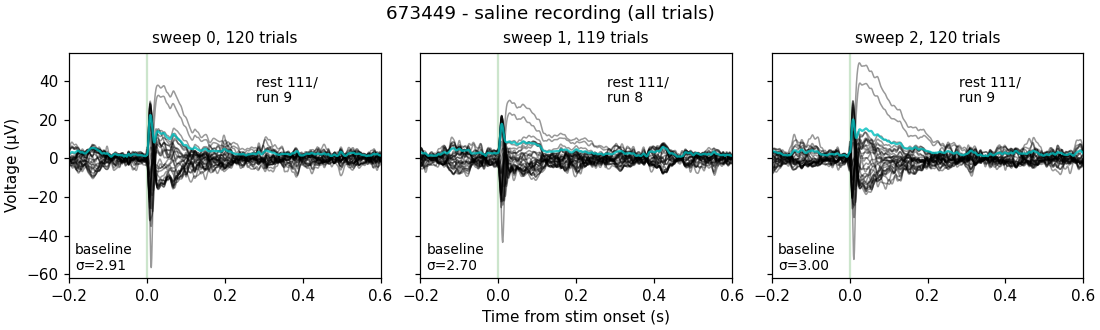

In [21]:
subject = '673449'
day = 'saline'
stim = 'biphasic'
curr = '40'
trials = 'all'
plot_window = [-0.2, 0.6]
good_chs = subjects_data[subject][day]['good_chs']

num_sweeps = len(subjects_data[subject][day]['EEG_traces'][stim][curr])

# fig, axs = plt.subplots(2, int(num_sweeps/2), figsize=(13, 5.5), constrained_layout=True, sharex=True, sharey=True)
fig, axs = plt.subplots(1, num_sweeps, figsize=(10, 3), constrained_layout=True, sharex=True, sharey=True)

for sweepi, axi in zip(range(num_sweeps), axs.flatten()):
    timex = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][0]
    traces = np.mean(subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][1], axis=2)
    num_trials = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][1].shape[2]
    BLstd = np.std(traces[:, good_chs][timex < 0, :])
    gfpow = np.std(traces[:, good_chs], axis=1)
    
    axi.axvline(0, color='g', alpha=0.2)
    axi.plot(timex, traces[:, good_chs], color='k', linewidth=1.0, alpha=0.4)
    axi.plot(timex, gfpow, color='c', linewidth=1.5, alpha=0.8)
    axi.annotate(
        'baseline\n\u03c3={:.2f}'.format(BLstd),
        xy=(0.02, 0.02), xycoords='axes fraction', fontsize=9, ha='left', va='bottom'
    )
    axi.set_title('sweep {:d}, {:d} trials'.format(sweepi, num_trials))
    
    rest_trials = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi]['resting'][1].shape[2]
    run_trials = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi]['running'][1].shape[2]
    axi.annotate(
        'rest {:d}/\nrun {:d}'.format(rest_trials, run_trials),
        xy=(0.6, 0.9), xycoords='axes fraction', fontsize=9, ha='left', va='top'
    )
    
# axs[0,0].set_xlim(plot_window)
# axs[0,0].set_ylabel('Voltage (\u03bcV)')
# axs[1,0].set_ylabel('Voltage (\u03bcV)')
# axs[1,2].set_xlabel('Time from stim onset (s)')
axs[0].set_xlim(plot_window)
axs[0].set_ylabel('Voltage (\u03bcV)')
axs[1].set_xlabel('Time from stim onset (s)')
plt.suptitle('{} - {} recording ({} trials)'.format(subject, day, trials))

## Save as .png ##
figname = 'EEG-ERP_allsweeps_{}_{}_{}trials.png'.format(subject, day, trials)
fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

<IPython.core.display.Javascript object>


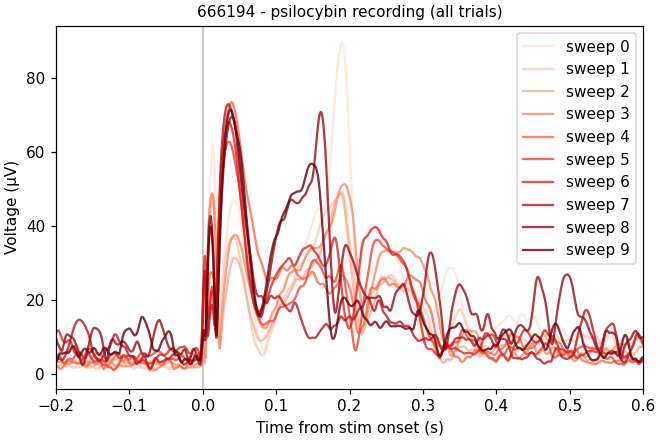

Text(0.5, 1.0, '666194 - psilocybin recording (all trials)')

In [25]:
subject = '666194'
day = 'psilocybin'
stim = 'biphasic'
curr = '40'
trials = 'all'
plot_window = [-0.2, 0.6]
good_chs = subjects_data[subject][day]['good_chs']

num_sweeps = len(subjects_data[subject][day]['EEG_traces'][stim][curr])
if day == 'saline':
    colors = plt.cm.Greys(np.linspace(0, 1, num_sweeps+1))
elif day == 'psilocybin':
    colors = plt.cm.Reds(np.linspace(0, 1, num_sweeps+1))

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.axvline(0, color='k', alpha=0.2)
for sweepi in range(num_sweeps):
    timex = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][0]
    traces = np.mean(subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][1], axis=2)
#     num_trials = subjects_data[subject][day]['EEG_traces'][stim][curr][sweepi][trials][1].shape[2]
    gfpow = np.std(traces[:, good_chs], axis=1)
    ax.plot(timex, gfpow, color=colors[sweepi+1], linewidth=1.5, alpha=0.8, label='sweep ' + str(sweepi))
    
ax.set_xlim(plot_window)
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_xlabel('Time from stim onset (s)')
ax.legend()
ax.set_title('{} - {} recording ({} trials)'.format(subject, day, trials))

### Calculating ERP metrics

In [27]:
subject = '666194'
day = 'saline'
stim = 'biphasic'
zlim = 3

good_chs = subjects_data[subject][day]['good_chs']
EEG_sample_rate = subjects_data[subject][day]['exp'].ephys_params['EEG']['sample_rate']

for curri, sweepdict in subjects_data[subject][day]['EEG_traces'][stim].items():
    sweep_info = subjects_data[subject][day]['sweep_info_df'][
        (subjects_data[subject][day]['sweep_info_df']['stim'] == stim) &
        (subjects_data[subject][day]['sweep_info_df']['parameter'] == curri)
    ].copy()
    sweep_metrics = []
    for sweepi, trialdict in sweepdict.items():
        trial_type_info = [sweepi]
        collabels = ['sweep']
        for trialtype, datai in trialdict.items():
            collabels.extend([trialtype + '_trial_count', trialtype + '_duration', trialtype + '_magnitude'])
            num_trials = datai[1].shape[2]
            EEG_time = datai[0]
            EEG_traces = datai[1]
            trial_type_info.append(num_trials)
            if num_trials == 0:
                print('*sweep {:d}: no {} trials*'.format(sweepi, trialtype))
                trial_type_info.extend([np.nan, np.nan])
                continue

            state_traces = np.mean(EEG_traces, axis=2)
            ## Calculate global field power duration ##
            gfpow = np.std(state_traces[:, good_chs], axis=1)
            blmean = np.mean(gfpow[EEG_time < 0])
            blstd = np.std(gfpow[EEG_time < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')
            trial_type_info.extend([response_duration, auc])
        sweep_metrics.append(trial_type_info)
    sweep_metrics_df = sweep_info.merge(pd.DataFrame(sweep_metrics, columns=collabels), on='sweep', how='left')

*sweep 1: no resting trials*
*sweep 9: no resting trials*


In [28]:
sweep_metrics_df.head()

,stim,parameter,sweep,sweep_onset,sweep_offset,sweep_time,all_trial_count,all_duration,all_magnitude,resting_trial_count,resting_duration,resting_magnitude,running_trial_count,running_duration,running_magnitude
0,biphasic,40,0,1237.13552,1708.90544,1472.922839,120,0.3864,6.566660,7,0.4692,3.037979,113,0.3488,5.952705
1,biphasic,40,1,2040.76826,2512.53861,2276.555779,120,0.4284,7.720646,0,NaN,NaN,120,0.4284,7.720646
2,biphasic,40,2,2802.29727,3274.06774,3038.084872,120,0.3364,4.854573,10,0.1312,0.479728,110,0.3656,5.321663
3,biphasic,40,3,3631.66392,4103.43434,3865.928553,119,0.2732,4.251281,3,0.1176,0.169967,116,0.2672,3.975655
4,biphasic,40,4,4425.39026,4897.16064,4661.177814,120,0.2612,2.461473,13,0.3464,1.673742,107,0.1868,1.970941


<IPython.core.display.Javascript object>


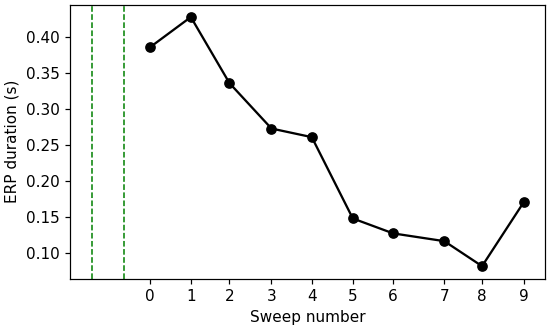

Text(0, 0.5, 'ERP duration (s)')

In [29]:
fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
for inji in subjects_data[subject][day]['inj_times']:
    ax.axvline(inji, color='g', linewidth=1.0, linestyle='dashed')
ax.plot(sweep_metrics_df['sweep_time'].values, sweep_metrics_df['all_duration'].values, color='k', marker='o')
ax.set_xticks(sweep_metrics_df['sweep_time'].values)
ax.set_xticklabels(sweep_metrics_df['sweep'].values)
ax.set_xlabel('Sweep number')
ax.set_ylabel('ERP duration (s)')